 **Atividade 4.2 - Hamilton Celerino da Fonseca Neto**

#Import

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from IPython.display import display, clear_output

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim


# Leitura, normalização e visualização dos dados

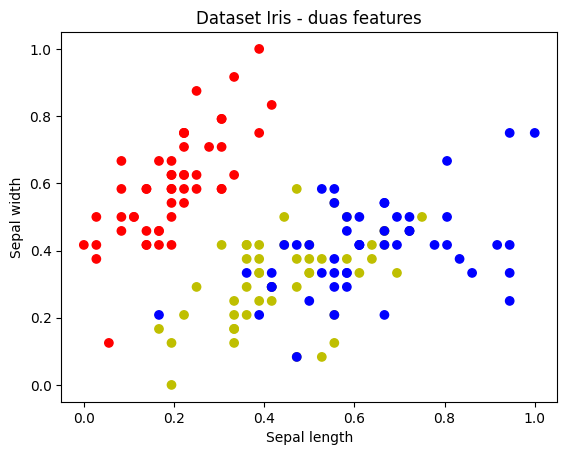

In [18]:
iris = datasets.load_iris()
X = iris.data[:, :2]
Xc = X - X.min(axis=0)
Xc /= Xc.max(axis=0)
Y = iris.target

# Convertendo para tensores PyTorch
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

# Visualização inicial
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title('Dataset Iris - duas features')
plt.show()


# Definindo Modelo

In [19]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )

    def forward(self, x):
        return self.dense(x)

model = Modelo()
print(model)


Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


# Função Predição

In [20]:
def predict(model, inputs):
    outputs = model(inputs)
    _, predicts = torch.max(outputs, 1)
    return predicts.data.numpy()


# Boundary Plotter

In [21]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, h=0.01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        self.loss_hist = []

        self.fig = plt.figure(figsize=(10, 4))
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlabel('Época')
        self.ax1.set_ylabel('Perda')
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(X[:,0].min(), X[:,0].max())
        self.ax2.set_ylim(X[:,1].min(), X[:,1].max())
        self.ax2.set_xlabel('Comprimento da sépala')
        self.ax2.set_ylabel('Largura da sépala')

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])
        if epoch % 250 == 0 or epoch == self.n_epoch-1:
            self.ax1.clear()
            self.ax1.set_xlabel('Época')
            self.ax1.set_ylabel('Perda')
            self.ax1.plot(np.arange(len(self.loss_hist)), self.loss_hist, 'b', linewidth=2.0, label='Treino')
            self.ax1.legend()
            self.ax1.grid(True)

            Z = predict(self.model, torch.from_numpy(self.X_grid).float())
            Z = Z.reshape(self.xx.shape)
            self.ax2.clear()
            self.ax2.set_xlim(self.X[:,0].min(), self.X[:,0].max())
            self.ax2.set_ylim(self.X[:,1].min(), self.X[:,1].max())
            self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
            colors = np.array(['r','y','b'])
            self.ax2.scatter(self.X[:, 0], self.X[:, 1], c=colors[self.Y], edgecolors='k')
            display(self.fig)
            clear_output(wait=True)


In [22]:
# Modelo 1: 2 camadas com ReLU
class ModeloReLU(nn.Module):
    def __init__(self):
        super(ModeloReLU, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 3)
        )
    def forward(self, x):
        return self.dense(x)

# Modelo 2: 2 camadas com Sigmoid
class ModeloSigmoid(nn.Module):
    def __init__(self):
        super(ModeloSigmoid, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 3)
        )
    def forward(self, x):
        return self.dense(x)

# Modelo 3: Sem ativação entre camadas
class ModeloLinear(nn.Module):
    def __init__(self):
        super(ModeloLinear, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 5),
            nn.Linear(5, 3)
        )
    def forward(self, x):
        return self.dense(x)


# Treinamento

In [23]:
def treinar_modelo(model, X_tensor, Y_tensor, lr=0.15, nb_epoch=3000):
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)
    losses = []
    for epoch in range(nb_epoch):
        output = model(X_tensor)
        loss = criterion(output, Y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        boundary_plot.on_epoch_end(epoch, {'loss': loss.item()})
    print('Final loss:', loss.item())
    return model


Final loss: 0.3693739175796509


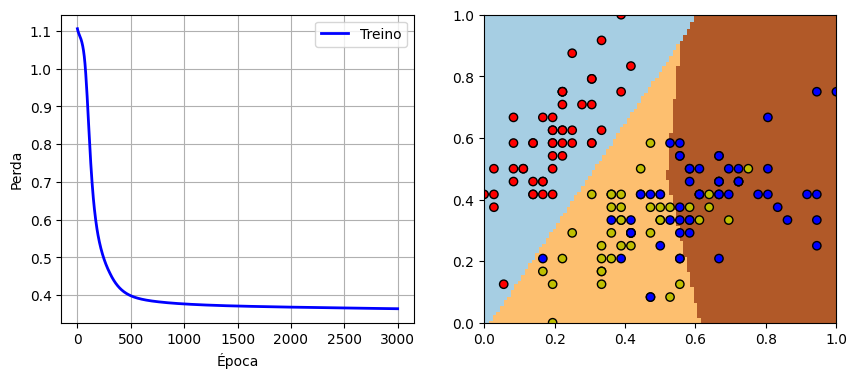

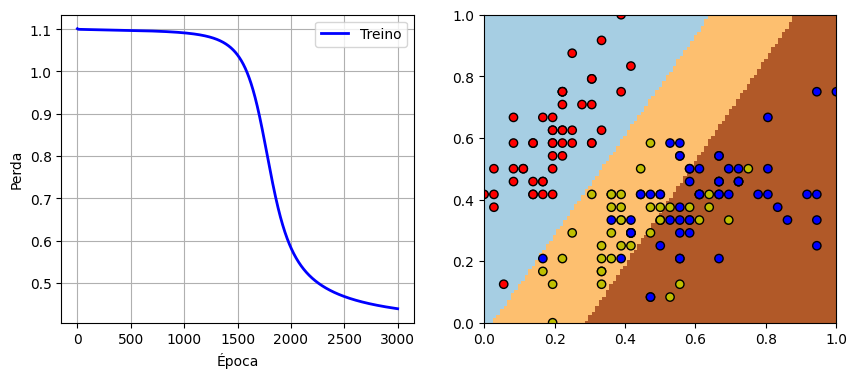

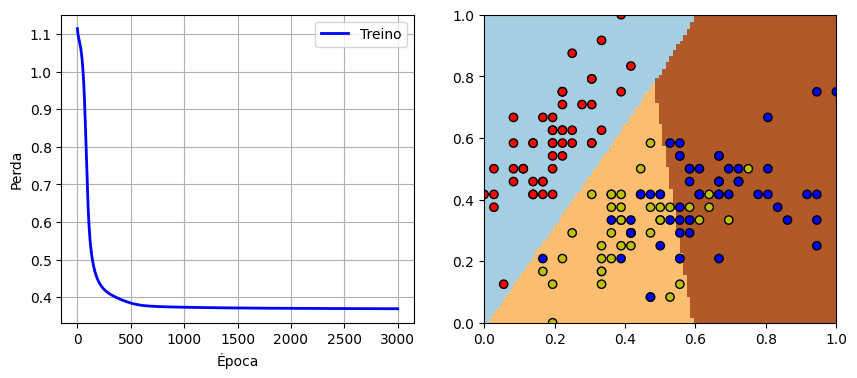

In [24]:
# Treinando modelo ReLU
print("Treinando modelo com ReLU")
model_relu = ModeloReLU()
model_relu = treinar_modelo(model_relu, X_tensor, Y_tensor)

# Treinando modelo Sigmoid
print("Treinando modelo com Sigmoid")
model_sigmoid = ModeloSigmoid()
model_sigmoid = treinar_modelo(model_sigmoid, X_tensor, Y_tensor)

# Treinando modelo Linear (sem ativação)
print("Treinando modelo sem ativação")
model_linear = ModeloLinear()
model_linear = treinar_modelo(model_linear, X_tensor, Y_tensor)


#Avaliação

In [25]:
for name, model in zip(['ReLU','Sigmoid','Linear'], [model_relu, model_sigmoid, model_linear]):
    Y_hat = predict(model, X_tensor)
    acc = (Y_hat == Y).mean()
    print(f'{name} Accuracy: {acc:.4f}')

ReLU Accuracy: 0.8333
Sigmoid Accuracy: 0.7933
Linear Accuracy: 0.8333


# Respostas:

**1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.**  
Mais neurônios ou camadas permitem capturar padrões complexos e reduzir perda, mas podem causar overfitting. Menos neurônios ou camadas limitam a capacidade da rede.

**2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.**  
O modelo aprende mais devagar e a perda final é maior. Isso ocorre porque Sigmoid sofre saturação do gradiente, tornando o treino mais lento. As fronteiras de decisão ficam mais suaves.

**3. O que ocorre quando não se utiliza ativação não linear entre camadas?**  
A rede se torna equivalente a uma transformação linear única. Não consegue aprender padrões não lineares e a acurácia cai significativamente.
